In [1]:
#pip install -q transformers

In [2]:
import pandas as pd
import shap
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [3]:
df = pd.read_csv("chime_comments.csv", skiprows=1)

In [4]:
df.head()

,Unnamed: 0,treatment_group,Age: 35-54,Age: 55+,Age: Under 35,Annual Income: $50-99K,Annual Income: HHI $100K or more,Annual Income: Less than $50K,"Banking Hidden Fee Experience: No, never","Banking Hidden Fee Experience: Yes, many times",...,Gender: Male,Region: Midwest,Region: Northeast,Region: South,Region: West,Social Media Use: TikTok Users,Urbanization: Rural,Urbanization: Suburban,Urbanization: Urban,Please share any reactions or feedback you have on the video.
0,6196c871a38a2f0029d4559d,#ChimeHasYourBack,False,True,False,False,False,False,True,False,...,True,False,False,False,True,False,False,False,True,Hated the video because I couldn’t stand the m...
1,6196c9c52545cb002736c8d9,Chime - Banking with No Hidden Fees,False,False,True,False,False,True,False,True,...,True,False,True,False,False,True,False,False,True,It was boring
2,6196ca0067efbf002649660b,Chime - Banking with No Hidden Fees,False,False,True,False,False,False,False,True,...,True,False,False,True,False,True,True,False,False,It was a very great positive video
3,6196ca46a38a2f0029d45748,Chime - Banking with No Hidden Fees,False,False,True,True,False,False,False,True,...,True,False,False,False,True,False,False,False,True,It passes a direct message
4,6196ca86d0549e0020564500,#ChimeHasYourBack,True,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,True,False,Watching the girl dance was fun


In [5]:
df = df.iloc[: , 1:] # drop first col

In [6]:
df

,treatment_group,Age: 35-54,Age: 55+,Age: Under 35,Annual Income: $50-99K,Annual Income: HHI $100K or more,Annual Income: Less than $50K,"Banking Hidden Fee Experience: No, never","Banking Hidden Fee Experience: Yes, many times","Banking Hidden Fee Experience: Yes, once or twice",...,Gender: Male,Region: Midwest,Region: Northeast,Region: South,Region: West,Social Media Use: TikTok Users,Urbanization: Rural,Urbanization: Suburban,Urbanization: Urban,Please share any reactions or feedback you have on the video.
0,#ChimeHasYourBack,False,True,False,False,False,False,True,False,False,...,True,False,False,False,True,False,False,False,True,Hated the video because I couldn’t stand the m...
1,Chime - Banking with No Hidden Fees,False,False,True,False,False,True,False,True,False,...,True,False,True,False,False,True,False,False,True,It was boring
2,Chime - Banking with No Hidden Fees,False,False,True,False,False,False,False,True,False,...,True,False,False,True,False,True,True,False,False,It was a very great positive video
3,Chime - Banking with No Hidden Fees,False,False,True,True,False,False,False,True,False,...,True,False,False,False,True,False,False,False,True,It passes a direct message
4,#ChimeHasYourBack,True,False,False,False,True,False,False,False,True,...,True,False,True,False,False,False,False,True,False,Watching the girl dance was fun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,#ChimeHasYourBack,False,True,False,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,The video was very intertaining.
920,Chime - Banking with No Hidden Fees,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,False,True,I feel like the ad could have went a little mo...
921,Chime - Banking with No Hidden Fees,False,False,True,False,False,True,False,False,True,...,False,False,False,True,False,True,False,False,True,Wow great video that's made it is well and ver...
922,#ChimeHasYourBack,False,False,True,False,False,False,True,False,False,...,True,False,False,True,False,False,False,False,True,The video was not consistent with the bank.


In [7]:
df.treatment_group.value_counts()

#ChimeHasYourBack                      340
Chime Credit Builder                   309
Chime - Banking with No Hidden Fees    275
Name: treatment_group, dtype: int64

In [8]:
# checking for missing values
df.isna().sum()

treatment_group                                                  0
Age: 35-54                                                       0
Age: 55+                                                         0
Age: Under 35                                                    0
Annual Income: $50-99K                                           0
Annual Income: HHI $100K or more                                 0
Annual Income: Less than $50K                                    0
Banking Hidden Fee Experience: No, never                         0
Banking Hidden Fee Experience: Yes, many times                   0
Banking Hidden Fee Experience: Yes, once or twice                0
Current Bank: Banking with Chime                                 0
Current Bank: Currently with other bank                          0
Current Bank: Unbanked                                           0
Education: College                                               0
Education: Non-College                                        

In [9]:
# replacing False with 0 and True with 1
df.replace({False: 0, True: 1}, inplace=True)

In [10]:
df.columns

Index(['treatment_group', 'Age: 35-54', 'Age: 55+', 'Age: Under 35',
       'Annual Income: $50-99K', 'Annual Income: HHI $100K or more',
       'Annual Income: Less than $50K',
       'Banking Hidden Fee Experience: No, never',
       'Banking Hidden Fee Experience: Yes, many times',
       'Banking Hidden Fee Experience: Yes, once or twice',
       'Current Bank: Banking with Chime',
       'Current Bank: Currently with other bank', 'Current Bank: Unbanked',
       'Education: College', 'Education: Non-College', 'Education: Postgrad',
       'Ethnicity: Asian', 'Ethnicity: Black', 'Ethnicity: Latinx',
       'Ethnicity: Other', 'Ethnicity: White', 'Gender: Female',
       'Gender: Male', 'Region: Midwest', 'Region: Northeast', 'Region: South',
       'Region: West', 'Social Media Use: TikTok Users', 'Urbanization: Rural',
       'Urbanization: Suburban', 'Urbanization: Urban',
       'Please share any reactions or feedback you have on the video.'],
      dtype='object')

Different sections:
* annual income
* banking hidden fee experience
* current bank
* education
* ethinicity
* gender
* region
* tiktok users?
* urbanization

In [11]:
comments = df.iloc[:,-1]

In [12]:
comments

0      Hated the video because I couldn’t stand the m...
1                                          It was boring
2                     It was a very great positive video
3                            It passes a direct message 
4                        Watching the girl dance was fun
                             ...                        
919                     The video was very intertaining.
920    I feel like the ad could have went a little mo...
921    Wow great video that's made it is well and ver...
922          The video was not consistent with the bank.
923    I thought maybe the video could have been a li...
Name: Please share any reactions or feedback you have on the video., Length: 924, dtype: object

In [13]:
sentiment_pipeline = pipeline("sentiment-analysis")
sentiment_outcomes = sentiment_pipeline(df.iloc[:,-1].tolist())

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [14]:
labels = [i['label'] for i in sentiment_outcomes]

In [15]:
df['labels'] = labels

In [16]:
df.head()

,treatment_group,Age: 35-54,Age: 55+,Age: Under 35,Annual Income: $50-99K,Annual Income: HHI $100K or more,Annual Income: Less than $50K,"Banking Hidden Fee Experience: No, never","Banking Hidden Fee Experience: Yes, many times","Banking Hidden Fee Experience: Yes, once or twice",...,Region: Midwest,Region: Northeast,Region: South,Region: West,Social Media Use: TikTok Users,Urbanization: Rural,Urbanization: Suburban,Urbanization: Urban,Please share any reactions or feedback you have on the video.,labels
0,#ChimeHasYourBack,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,Hated the video because I couldn’t stand the m...,NEGATIVE
1,Chime - Banking with No Hidden Fees,0,0,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,It was boring,NEGATIVE
2,Chime - Banking with No Hidden Fees,0,0,1,0,0,0,0,1,0,...,0,0,1,0,1,1,0,0,It was a very great positive video,POSITIVE
3,Chime - Banking with No Hidden Fees,0,0,1,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,It passes a direct message,NEGATIVE
4,#ChimeHasYourBack,1,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,Watching the girl dance was fun,POSITIVE


In [17]:
df.treatment_group.value_counts()

#ChimeHasYourBack                      340
Chime Credit Builder                   309
Chime - Banking with No Hidden Fees    275
Name: treatment_group, dtype: int64

In [18]:
df1 = df[df['treatment_group'] == "#ChimeHasYourBack"]
df2 = df[df['treatment_group'] == "Chime - Banking with No Hidden Fees"]
df3 = df[df['treatment_group'] == "Chime Credit Builder"]

In [19]:
subset = df.iloc[:,-2:]

In [20]:
subset

,Please share any reactions or feedback you have on the video.,labels
0,Hated the video because I couldn’t stand the m...,NEGATIVE
1,It was boring,NEGATIVE
2,It was a very great positive video,POSITIVE
3,It passes a direct message,NEGATIVE
4,Watching the girl dance was fun,POSITIVE
...,...,...
919,The video was very intertaining.,POSITIVE
920,I feel like the ad could have went a little mo...,NEGATIVE
921,Wow great video that's made it is well and ver...,POSITIVE
922,The video was not consistent with the bank.,NEGATIVE


In [21]:
subset.replace({"NEGATIVE": 0, "POSITIVE": 1}, inplace=True)

In [22]:
vectorizer = TfidfVectorizer()

In [23]:
corpus_train, corpus_test, y_train, y_test = train_test_split(subset.iloc[:,0].tolist(), subset['labels'], test_size=0.2, random_state=42)

In [24]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
y_pred = model.predict(X_test)
lg_accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", lg_accuracy)

Accuracy: 0.827027027027027


In [27]:
np.mean(y_test)

0.6594594594594595

In [28]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [29]:
shap_values = explainer.shap_values(X_test)

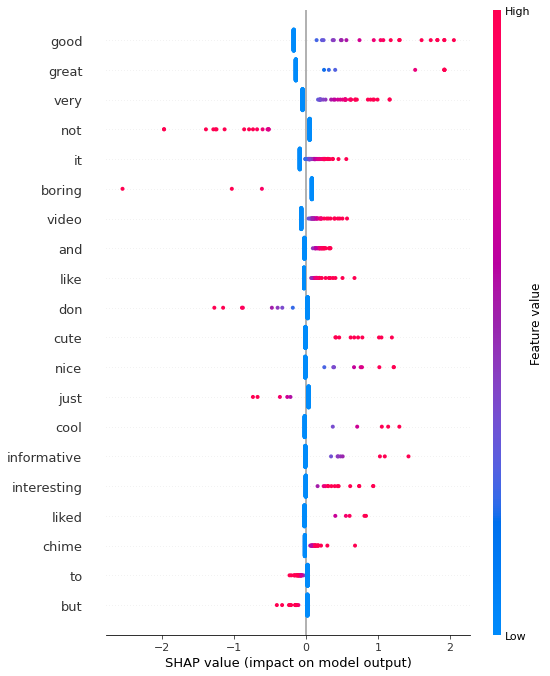

In [30]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

In [31]:
shap.initjs()
idx = 3
print("Positive" if y_test.tolist()[idx] else "Negative", "Comment:")
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Positive Comment:
Was interesting and entertaining told a lot about chime


In [32]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1])

In [33]:
# Separating into groups depending on treatment group
df1 = df[df['treatment_group'] == "#ChimeHasYourBack"]
df2 = df[df['treatment_group'] == "Chime - Banking with No Hidden Fees"]
df3 = df[df['treatment_group'] == "Chime Credit Builder"]

In [34]:
df1.drop(columns=["Please share any reactions or feedback you have on the video."], axis=1, inplace=True)
df2.drop(columns=["Please share any reactions or feedback you have on the video."], axis=1, inplace=True)
df3.drop(columns=["Please share any reactions or feedback you have on the video."], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
df.treatment_group.unique()[0]

'#ChimeHasYourBack'

In [36]:
print("Summary plot for advertisement", df.treatment_group.unique()[0])

Summary plot for advertisement #ChimeHasYourBack


In [37]:
y1 = df1["labels"]
x1 = df1.drop(columns=["treatment_group","labels"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.2, random_state = 42)

classifier = LogisticRegression(random_state=42)
classifier.fit(x_train,y_train)

y_pred = classifier.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred)*100)

Accuracy: 73.52941176470588


In [38]:
explainer = shap.LinearExplainer(classifier, x_train, feature_perturbation='interventional')
shap_values = explainer.shap_values(x_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


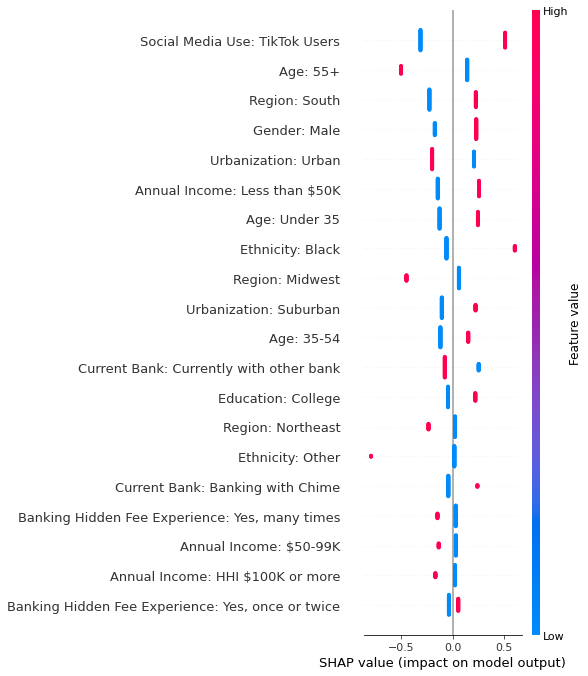

In [39]:
# summary plot for features
x_test_array = np.asarray(x_test)
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)

Understanding the plot above:

* the topmost feature is the most important one so TikTok Users and people over the age of 55 influence the comments the most. Furthermore, the red line shows whether this influence is positive or negative. Here, TikTok users like this 

In [40]:
print("Summary plot for advertisement", df.treatment_group.unique()[1])

Summary plot for advertisement Chime - Banking with No Hidden Fees


In [41]:
y2 = df2["labels"]
x2 = df2.drop(columns=["treatment_group","labels"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.2, random_state = 42)

classifier = LogisticRegression(random_state=42)
classifier.fit(x_train,y_train)

y_pred = classifier.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred)*100)

Accuracy: 72.72727272727273


In [42]:
explainer = shap.LinearExplainer(classifier, x_train, feature_perturbation='interventional')
shap_values = explainer.shap_values(x_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


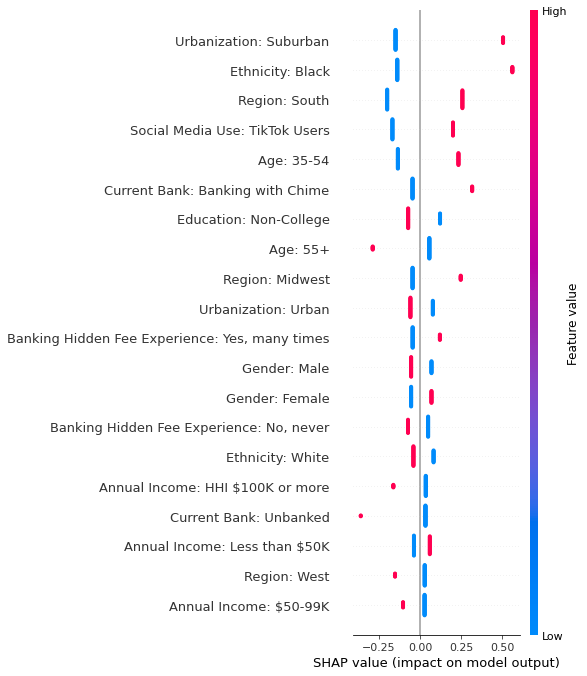

In [43]:
# summary plot for features
x_test_array = np.asarray(x_test)
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)

In [44]:
print("Summary plot for advertisement", df.treatment_group.unique()[2])

Summary plot for advertisement Chime Credit Builder


In [45]:
y3 = df3["labels"]
x3 = df3.drop(columns=["treatment_group","labels"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x3, y3, test_size = 0.2, random_state = 42)

classifier = LogisticRegression(random_state=42)
classifier.fit(x_train,y_train)

y_pred = classifier.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred)*100)

Accuracy: 77.41935483870968


In [46]:
explainer = shap.LinearExplainer(classifier, x_train, feature_perturbation='interventional')
shap_values = explainer.shap_values(x_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


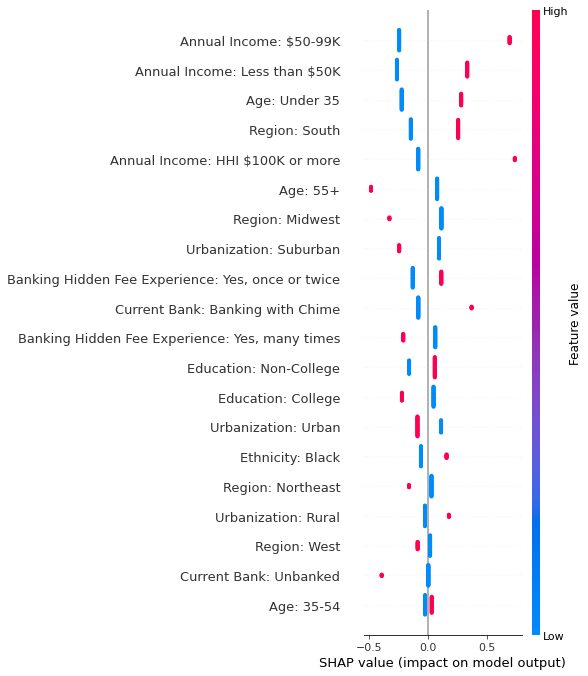

In [47]:
# summary plot for features
x_test_array = np.asarray(x_test)
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)